In [ ]:
'''
Marco Costante, Alessandra Stramiglio
MSc student in Artificial Intelligence
@ Alma Mater Studiorum, University of Bologna
October, 2021
'''

#Bayesian network model for medical diagnosis of the respiratory system

The symptom dyspnea (shortness of breath) may be due to the diseases pneumonia, lung cancer, and/or bronchitis. Patients with pneumonia, and/or bronchitis often have a very nasty wet coughing. Pneumonia, and/or lung cancer are often accompanied by a heavy chest pain. Pneumonia is often causing a severe fever, but this may also be caused by a common cold. However, a common cold is often recognized by a runny nose. Sometimes, wet coughing, chest pain, and/or dyspnea occurs unexplained, or are due to another cause, without any of these diseases being present. Sometimes diseases co-occur. A weakened immune-system (for instance, homeless people, or HIV infected) increases the probability of getting an pneumonia. Also, lung cancer increases this probability. Smoking is a serious risk factor for bronchitis and for lung cancer.

##Imports

In [ ]:
import sys
!{sys.executable} -m pip install pgmpy==0.1.14
!{sys.executable} -m pip install --upgrade pip

In [ ]:
from pgmpy.models import BayesianModel
from pgmpy.factors.discrete import TabularCPD
from pgmpy.inference import VariableElimination

import networkx as nx
import matplotlib.pyplot as plt

from pgmpy.sampling import BayesianModelSampling
from pgmpy.factors.discrete import State
import numpy as np

#1. Modeling
Bayesian networks are a formalism of knowledge representation to express domains that can be characterized by probability distribution. This is a way to capture all the independencies in the domain and hence for compact specification of full joint distributions.
A Bayesian network is a directed, acyclic graph with a set of nodes, one per variable, and a conditional distribution for each node given its parents: `P(X_i|Parents(X_i))`. Nodes are connected to each other through edges, which capture independence.


Now to build a model, we first have to find out which are the variables. In a realistic medical application, one may want to model multi-state variables. For simplicity, however, we take in this example all variables binary (true/false). Note that by modeling diseases as separate variables rather than by mutually exclusive states in a single disease variable, the model allows diseases to co-occur.

##1.1 Nodes name definitions

In [ ]:
immun_sys = "Immun sys"
smoking = "Smoking"
comm_cold = "Comm cold"
pneumonia = "Pneumonia"
lung_cancer = "Lung cancer"
bronchitis = "Bronchitis"
runny_nose = "Runny nose"
fever = "Fever"
chest_pain = "Chest pain"
coughing = "Coughing"
dyspnea = "Dyspnea"



names = [immun_sys, smoking, comm_cold, pneumonia, lung_cancer,
         bronchitis, runny_nose, fever, chest_pain, coughing, dyspnea]

##1.2 Model definition

In [ ]:
model = BayesianModel([(immun_sys, pneumonia), (smoking, lung_cancer), (smoking, bronchitis), 
                       (comm_cold, runny_nose), (comm_cold, fever), (pneumonia, fever), (pneumonia, chest_pain),
                       (pneumonia, coughing), (pneumonia, dyspnea), (lung_cancer, pneumonia), 
                       (lung_cancer, chest_pain), (lung_cancer, dyspnea), (bronchitis, coughing), (bronchitis, dyspnea)])



nodes = list(model.nodes())
edges = list(model.edges())

print('The nodes of the net are: {}'.format(nodes))
print('The edges of the net are: {}'.format(edges))

The nodes of the net are: ['Immun sys', 'Pneumonia', 'Smoking', 'Lung cancer', 'Bronchitis', 'Comm cold', 'Runny nose', 'Fever', 'Chest pain', 'Coughing', 'Dyspnea']
The edges of the net are: [('Immun sys', 'Pneumonia'), ('Pneumonia', 'Fever'), ('Pneumonia', 'Chest pain'), ('Pneumonia', 'Coughing'), ('Pneumonia', 'Dyspnea'), ('Smoking', 'Lung cancer'), ('Smoking', 'Bronchitis'), ('Lung cancer', 'Pneumonia'), ('Lung cancer', 'Chest pain'), ('Lung cancer', 'Dyspnea'), ('Bronchitis', 'Coughing'), ('Bronchitis', 'Dyspnea'), ('Comm cold', 'Runny nose'), ('Comm cold', 'Fever')]


##1.3 Model representation

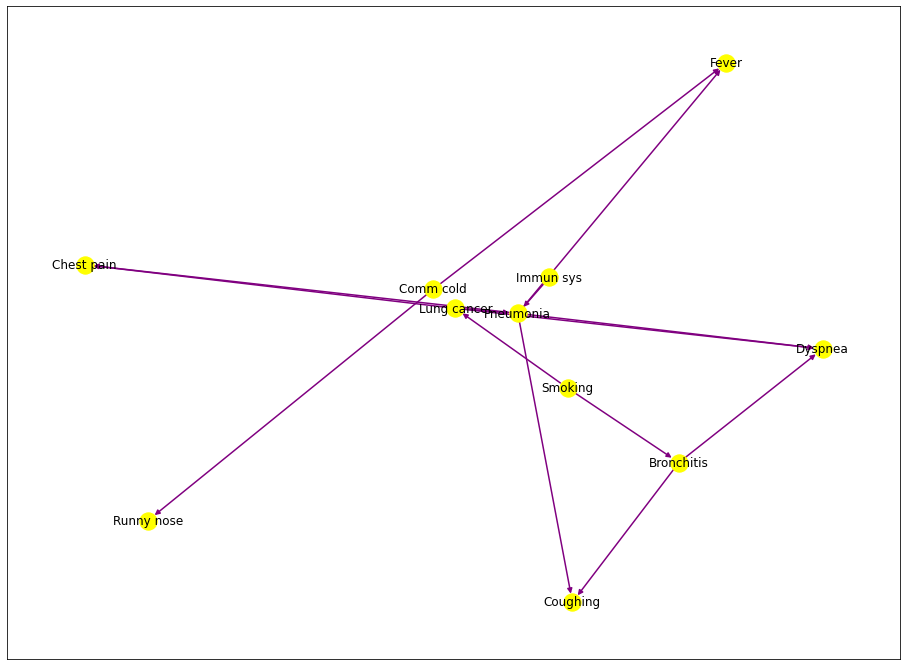

In [ ]:
DAG = nx.DiGraph()
DAG.add_edges_from(edges)

fig = plt.figure(figsize = (16,12))
pos = nx.spring_layout(DAG) 

nx.draw_networkx_nodes(DAG, pos = pos, node_color = 'yellow')
nx.draw_networkx_labels(DAG, pos = pos)
nx.draw_networkx_edges(DAG, pos = pos, edge_color = 'purple', width = 1.5, arrows = True)

plt.show()

##1.4 Graph structure

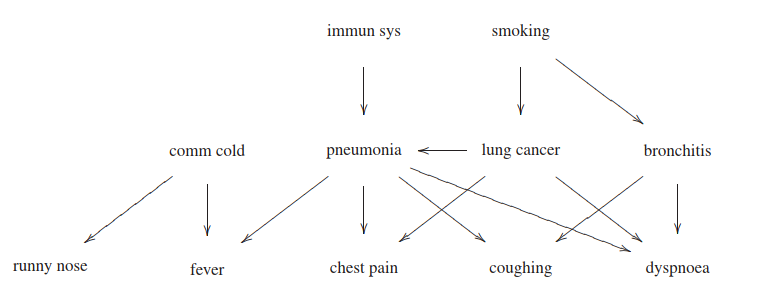

#2. CPD definition
Given two jointly distributed random variables X and Y, the conditional probability distribution of Y given X is the probability distribution of Y when X is known to be a particular value. Conditional Probability Tables (CPT) are an easy way to represent Conditional Probability Distributions (CPD) in form of table.

##2.1 Simple CPD
Each variable X in the model is associated with a conditional probability distribution (CPD) that specifies a distribution over the values of X given each possible joint assignment of values to its parents in the model.
For a node with no parents, the CPD is conditioned on the empty set of variables. Hence, the CPD turns into a marginal distribution, such as P(D).

In [ ]:
cpds = {}

# P(immun_sys)
cpd_immun_sys = TabularCPD(variable = immun_sys, 
                     variable_card = 2,
                     values = [[0.05], 
                               [0.95]],
                     state_names = {immun_sys : ['True', 'False']})

print("P(immun_sys)")
print(cpd_immun_sys)

cpds[immun_sys] = cpd_immun_sys

# P(smoking)
cpd_smoking = TabularCPD(variable = smoking, 
                     variable_card = 2,
                     values = [[0.3], 
                               [0.7]],
                     state_names = {smoking : ['True', 'False']})

print("P(smoking)")
print(cpd_smoking)

cpds[smoking] = cpd_smoking

# P(comm_cold)
cpd_cc = TabularCPD(variable = comm_cold, 
                     variable_card = 2,
                     values = [[0.35], 
                               [0.65]],
                     state_names = {comm_cold : ['True', 'False']})

print("P(comm_cold)")
print(cpd_cc)

cpds[comm_cold] = cpd_cc

P(immun_sys)
+------------------+------+
| Immun sys(True)  | 0.05 |
+------------------+------+
| Immun sys(False) | 0.95 |
+------------------+------+
P(smoking)
+----------------+-----+
| Smoking(True)  | 0.3 |
+----------------+-----+
| Smoking(False) | 0.7 |
+----------------+-----+
P(comm_cold)
+------------------+------+
| Comm cold(True)  | 0.35 |
+------------------+------+
| Comm cold(False) | 0.65 |
+------------------+------+


##2.2 CPD with evidence
For a node X with parents, we have to consider the conditional probability distribution with the evidence of the value of the parent node Y. So the probability of X to occur is the probability of event X occurring, given that event Y occurs.

In [ ]:
# P(lung_cancer|smoking)
cpd_lung_cancer = TabularCPD(variable = lung_cancer,
                                   variable_card = 2,
                                   values = [[0.1, 0.01],
                                             [0.9, 0.99]],
                                   evidence = [smoking],
                                   evidence_card = [2],
                                   state_names = {lung_cancer:['True','False'],
                                                  smoking : ['True','False']
                                                  }
                                   )

print("P(lung_cancer|smoking)")
print(cpd_lung_cancer)

cpds[lung_cancer] = cpd_lung_cancer

# P(bronchitis|smoking)
cpd_bronchitis = TabularCPD(variable = bronchitis,
                                   variable_card = 2,
                                   values = [[0.3, 0.01],
                                             [0.7, 0.99]],
                                   evidence = [smoking],
                                   evidence_card = [2],
                                   state_names = {bronchitis:['True','False'],
                                                  smoking : ['True','False']
                                                  }
                                   )

print("P(bronchitis|smoking)")
print(cpd_bronchitis)

cpds[bronchitis] = cpd_bronchitis

# P(runny_nose|comm_cold)
cpd_runny_nose = TabularCPD(variable = runny_nose,
                                   variable_card = 2,
                                   values = [[0.9, 0.01],
                                             [0.1, 0.99]],
                                   evidence = [comm_cold],
                                   evidence_card = [2],
                                   state_names = {runny_nose:['True','False'],
                                                  comm_cold : ['True','False']
                                                  }
                                   )

print("P(runny_nose|comm_cold)")
print(cpd_runny_nose)

cpds[runny_nose] = cpd_runny_nose

# P(pneumonia|immun_sys, lung_cancer)
cpd_pneumonia = TabularCPD(variable = pneumonia,
                                   variable_card = 2,
                                   values = [[0.3, 0.3, 0.05, 0.001],
                                             [0.7, 0.7, 0.95, 0.999]],
                                   evidence = [immun_sys, lung_cancer],
                                   evidence_card = [2, 2],
                                   state_names = {pneumonia:['True','False'],
                                                  immun_sys: ['True','False'],
                                                  lung_cancer: ['True','False']
                                                  }
                                   )

print("P(pneumonia|immun_sys, lung_cancer)")
print(cpd_pneumonia)

cpds[pneumonia] = cpd_pneumonia

# P(fever|pneumonia, comm_cold)
cpd_fever = TabularCPD(variable = fever,
                                   variable_card = 2,
                                   values = [[0.9, 0.9, 0.2, 0.01],
                                             [0.1, 0.1, 0.8, 0.99]],
                                   evidence = [pneumonia, comm_cold],
                                   evidence_card = [2, 2],
                                   state_names = {fever:['True','False'],
                                                  pneumonia : ['True','False'],
                                                  comm_cold: ['True','False']
                                                  }
                                   )

print("P(fever|pneumonia, comm_cold)")
print(cpd_fever)

cpds[fever] = cpd_fever

# P(coughing|pneumonia, bronchitis)
cpd_cough = TabularCPD(variable = coughing,
                                   variable_card = 2,
                                   values = [[0.9, 0.9, 0.9, 0.1],
                                             [0.1, 0.1, 0.1, 0.9]],
                                   evidence = [pneumonia, bronchitis],
                                   evidence_card = [2, 2],
                                   state_names = {coughing:['True','False'],
                                                  pneumonia : ['True','False'],
                                                  bronchitis: ['True','False']
                                                  }
                                   )

print("P(coughing|pneumonia, bronchitis)")
print(cpd_cough)

cpds[coughing] = cpd_cough

# P(chest_pain|pneumonia, bronchitis)
cpd_chest_pain = TabularCPD(variable = chest_pain,
                                   variable_card = 2,
                                   values = [[0.9, 0.9, 0.9, 0.1],
                                             [0.1, 0.1, 0.1, 0.9]],
                                   evidence = [pneumonia, lung_cancer],
                                   evidence_card = [2, 2],
                                   state_names = {chest_pain:['True','False'],
                                                  pneumonia : ['True','False'],
                                                  lung_cancer: ['True','False']
                                                  }
                                   )

print("P(chest_pain|pneumonia, bronchitis)")
print(cpd_chest_pain)

cpds[chest_pain] = cpd_chest_pain

# P(dyspnea|bronchitis, lung_cancer, pneumonia)
cpd_dyspnea = TabularCPD(variable = dyspnea,
                                   variable_card = 2,
                                   values = [[0.8, 0.8, 0.8, 0.8,  0.5, 0.5, 0.5, 0.1],
                                             [0.2, 0.2, 0.2, 0.2, 0.5, 0.5, 0.5, 0.9]],
                                   evidence = [bronchitis, lung_cancer, pneumonia],
                                   evidence_card = [2, 2, 2],
                                   state_names = {dyspnea:['True','False'],
                                                  bronchitis: ['True','False'],
                                                  lung_cancer: ['True', 'False'],
                                                  pneumonia : ['True','False'],
                                                  }
                                   )

print("P(dyspnea|bronchitis, lung_cancer, pneumonia)")
print(cpd_dyspnea)

cpds[dyspnea] = cpd_dyspnea

P(lung_cancer|smoking)
+--------------------+---------------+----------------+
| Smoking            | Smoking(True) | Smoking(False) |
+--------------------+---------------+----------------+
| Lung cancer(True)  | 0.1           | 0.01           |
+--------------------+---------------+----------------+
| Lung cancer(False) | 0.9           | 0.99           |
+--------------------+---------------+----------------+
P(bronchitis|smoking)
+-------------------+---------------+----------------+
| Smoking           | Smoking(True) | Smoking(False) |
+-------------------+---------------+----------------+
| Bronchitis(True)  | 0.3           | 0.01           |
+-------------------+---------------+----------------+
| Bronchitis(False) | 0.7           | 0.99           |
+-------------------+---------------+----------------+
P(runny_nose|comm_cold)
+-------------------+-----------------+------------------+
| Comm cold         | Comm cold(True) | Comm cold(False) |
+-------------------+---------------

In [ ]:
values = list(cpds.values())

[model.add_cpds(x) for x in values];



Check if the CPDs are consistent with the nodes and the model:


In [ ]:
model.check_model()

True

#3. Independencies
Independence can be defined in 3 different ways:

- A is independent of B if the probability of A is independent from B;
- viceversa as before;
- probability of having both A and B is the same of having the product of the probability of A and the probability of B.


In [ ]:
print('There can be made {} valid independence assertions, with respect to the all possible given evidence.'.format(len(model.get_independencies().get_assertions())), "\n")
independencies = model.get_independencies() 
# print(independencies) # Output is not shown for compactness sake

for name in names:
  print("The local independencies for \'{}\' are:".format(name), "\n" ,model.local_independencies(name), "\n")

There can be made 8602 valid independence assertions, with respect to the all possible given evidence. 

The local independencies for 'Immun sys' are: 
 (Immun sys ⟂ Runny nose, Lung cancer, Comm cold, Bronchitis, Smoking) 

The local independencies for 'Smoking' are: 
 (Smoking ⟂ Comm cold, Immun sys, Runny nose) 

The local independencies for 'Comm cold' are: 
 (Comm cold ⟂ Pneumonia, Dyspnea, Bronchitis, Chest pain, Smoking, Lung cancer, Immun sys, Coughing) 

The local independencies for 'Pneumonia' are: 
 (Pneumonia ⟂ Comm cold, Bronchitis, Runny nose, Smoking | Immun sys, Lung cancer) 

The local independencies for 'Lung cancer' are: 
 (Lung cancer ⟂ Comm cold, Immun sys, Bronchitis, Runny nose | Smoking) 

The local independencies for 'Bronchitis' are: 
 (Bronchitis ⟂ Pneumonia, Runny nose, Immun sys, Fever, Lung cancer, Comm cold, Chest pain | Smoking) 

The local independencies for 'Runny nose' are: 
 (Runny nose ⟂ Pneumonia, Bronchitis, Dyspnea, Smoking, Chest pain, Fever, Lu

##3.1 Markov blanket

The Markov blanket of a given node (in red) consists in the set (in yellow) of:

- Its parents; 
- Its children; 
- Its children’s other parents. 

Each node is conditionally independent of all others, given its Markov Blanket.

Once you know this kind of evidence, whatever happens outside does not influence this.

The node 'Immun sys' has Markov blanket: ['Pneumonia', 'Lung cancer'].




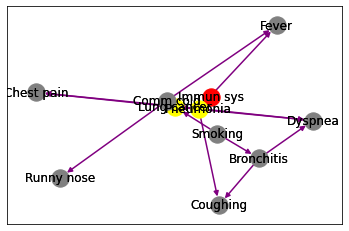



❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈ 

The node 'Pneumonia' has Markov blanket: ['Comm cold', 'Dyspnea', 'Bronchitis', 'Chest pain', 'Fever', 'Lung cancer', 'Immun sys', 'Coughing'].




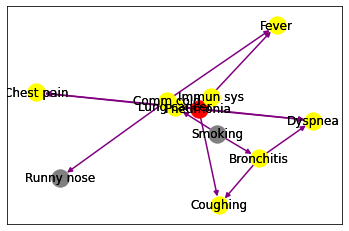



❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈ 

The node 'Smoking' has Markov blanket: ['Bronchitis', 'Lung cancer'].




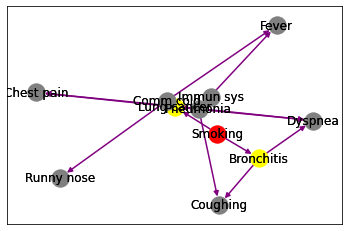



❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈ 

The node 'Lung cancer' has Markov blanket: ['Pneumonia', 'Dyspnea', 'Bronchitis', 'Smoking', 'Chest pain', 'Immun sys'].




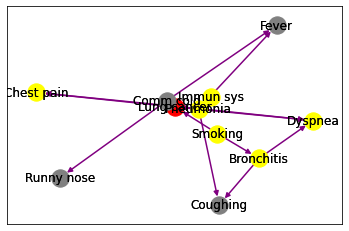



❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈ 

The node 'Bronchitis' has Markov blanket: ['Pneumonia', 'Dyspnea', 'Smoking', 'Lung cancer', 'Coughing'].




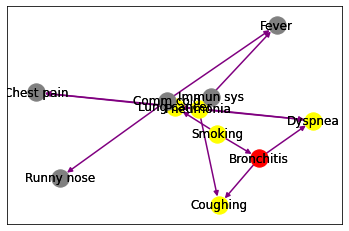



❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈ 

The node 'Comm cold' has Markov blanket: ['Pneumonia', 'Runny nose', 'Fever'].




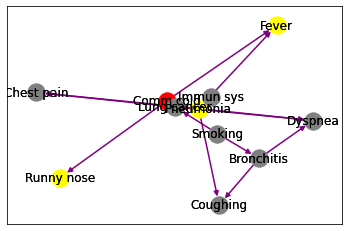



❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈ 



In [ ]:
leaves = model.get_leaves()
markov_blanket = {}

for node in nodes:
    if not node in leaves:
        markov_blanket[node] = model.get_markov_blanket(node)
        print('The node \'{}\' has Markov blanket: {}.'.format(node, markov_blanket[node]))
        print('\n')
        
        nx.draw_networkx_nodes(DAG, pos, nodelist = [node], node_color = 'red')
        nx.draw_networkx_nodes(DAG, pos, nodelist = markov_blanket[node], node_color = 'yellow')
        nx.draw_networkx_nodes(DAG, pos, 
               nodelist = [n for n in nodes if n not in markov_blanket[node] and n != node], 
               node_color = 'grey')
        nx.draw_networkx_labels(DAG, pos)
        nx.draw_networkx_labels(DAG, pos)
        nx.draw_networkx_edges(DAG, pos, edge_color = 'purple', width = 1.5, arrows = True)
        plt.show()

        print('\n')
        print("❈"*85,"\n")



#4. Queries


Starting from an observed event, it's possible to compute the posterios probability distribuition for a set of query variables, which indeed is the basic task of any probabilistic inference system. In order to do so we need to assign some values to a set of evidences.

##4.1 Exact inference
For the exact inference the most common and used method is the one of **variable elimination**, which computes subexpressions only once.

 This inference method is called Variable Elimination because it eliminates one by one those variables which are irrelevant for the query. First, the algorithm acts on a set of factors. Each
factor f involves a set of variables {X1, X2,...., Xk} and maps instantiations of those variables to real–numbers. The initial set of factors are the network’s conditional probability distributions (CPTs). Elimination is driven by an ordering on the variables called an elimination order. During the algorithm, two factor operations are performed many times: factors are multiplied and a variable is summed out of a factor. These factor operations reduce to performing many multiplication and addition operations on real–numbers. 

In [ ]:
exact_inference_variable_elimination = VariableElimination(model)

The following simple query shows us that the probability to suffer of pneumonia is very low:

In [ ]:
print('P(pneumonia)')
query1 = exact_inference_variable_elimination.query([pneumonia], show_progress = False);
print(query1)

P(pneumonia)
+------------------+------------------+
| Pneumonia        |   phi(Pneumonia) |
+==================+==================+
| Pneumonia(True)  |           0.0177 |
+------------------+------------------+
| Pneumonia(False) |           0.9823 |
+------------------+------------------+


The following queries are made using exact inference with variable elimination:

In [ ]:
print('P(pneumonia | fever = True, runny nose = False)')
query2 = exact_inference_variable_elimination.query([pneumonia], {fever : 'True', runny_nose : 'False'}, show_progress = False);
print(query2)

P(pneumonia | fever = True, runny nose = False)
+------------------+------------------+
| Pneumonia        |   phi(Pneumonia) |
+==================+==================+
| Pneumonia(True)  |           0.4499 |
+------------------+------------------+
| Pneumonia(False) |           0.5501 |
+------------------+------------------+


In [ ]:
print('P(lung cancer | chest pain = True, dyspnea = True, fever = False, coughing = false)')
query3 = exact_inference_variable_elimination.query([lung_cancer], {chest_pain : 'True', dyspnea : 'True', fever : 'False', coughing : 'False'}, show_progress = False);
print(query3)

P(lung cancer | chest pain = True, dyspnea = True, fever = False, coughing = false)
+--------------------+--------------------+
| Lung cancer        |   phi(Lung cancer) |
+====================+====================+
| Lung cancer(True)  |             0.5686 |
+--------------------+--------------------+
| Lung cancer(False) |             0.4314 |
+--------------------+--------------------+


In [ ]:
print('P(pneumonia | chest pain = True, dyspnea = True, fever = False, coughing = false)')
query4 = exact_inference_variable_elimination.query([pneumonia], {chest_pain : 'True', dyspnea : 'True', fever : 'False', coughing : 'False'}, show_progress = False);
print(query4)

P(pneumonia | chest pain = True, dyspnea = True, fever = False, coughing = false)
+------------------+------------------+
| Pneumonia        |   phi(Pneumonia) |
+==================+==================+
| Pneumonia(True)  |           0.0047 |
+------------------+------------------+
| Pneumonia(False) |           0.9953 |
+------------------+------------------+


In [ ]:
print('P(lung cancer | bronchitis = True)')
query5 = exact_inference_variable_elimination.query([lung_cancer], {bronchitis : 'True'}, show_progress = False);
print(query5)

P(lung cancer | bronchitis = True)
+--------------------+--------------------+
| Lung cancer        |   phi(Lung cancer) |
+====================+====================+
| Lung cancer(True)  |             0.0935 |
+--------------------+--------------------+
| Lung cancer(False) |             0.9065 |
+--------------------+--------------------+


In [ ]:
print('P(bronchitis | lung cancer = True)')
query6 = exact_inference_variable_elimination.query([bronchitis], {lung_cancer : 'True'}, show_progress = False);
print(query6)

P(bronchitis | lung cancer = True)
+-------------------+-------------------+
| Bronchitis        |   phi(Bronchitis) |
+===================+===================+
| Bronchitis(True)  |            0.2451 |
+-------------------+-------------------+
| Bronchitis(False) |            0.7549 |
+-------------------+-------------------+


The following queries are useful for diagnosis purposes and are done with **map queries**. In a map query we have a set of variables like Y and we want to know what is the most probable assignment of this set Y given the evidence.



In [ ]:
print('Diagnosis given fever and runny nose')
query6 = exact_inference_variable_elimination.map_query([pneumonia, bronchitis, comm_cold, lung_cancer], {fever : 'True', runny_nose : 'True', smoking : 'False', immun_sys : 'False'}, show_progress = False)
print(query6)

Diagnosis given fever and runny nose
{'Pneumonia': 'False', 'Bronchitis': 'False', 'Comm cold': 'True', 'Lung cancer': 'False'}


In [ ]:
print('Diagnosis given fever, runny nose and weakened immune system')
query7 = exact_inference_variable_elimination.map_query([pneumonia, bronchitis, comm_cold, lung_cancer], {fever : 'True', runny_nose : 'True', immun_sys : 'True'}, show_progress = False)
print(query7)

Diagnosis given fever, runny nose and weakened immune system
{'Pneumonia': 'True', 'Bronchitis': 'False', 'Comm cold': 'True', 'Lung cancer': 'False'}


In [ ]:
print('Diagnosis given pneumonia and smoking')
query8 = exact_inference_variable_elimination.map_query([bronchitis, comm_cold, lung_cancer], {pneumonia : 'True', smoking : 'True', immun_sys : 'False'}, show_progress = False)
print(query8)

Diagnosis given pneumonia and smoking
{'Bronchitis': 'False', 'Comm cold': 'False', 'Lung cancer': 'True'}


##4.2 Approximate Inference

Exact inference for small networks is very efficient and fast, on the contrary approximate inference can take a while. Approximate inference are used in networks with some distributions that are not represented by discrete variables, and so the factor products are not applicable anymore.
 
The idea behind approximate inference is very simple: in stochastic simulations you draw a number of samples from a sampling distribution, then you compute an approximate posterior probability. 
Hence for approximate inference we are actually using a frequentist approach rather than bayesian one.



In [ ]:
# Exact Inference 
reference_query = exact_inference_variable_elimination.query([pneumonia], {fever :'True', runny_nose: 'False'}, show_progress = False).values[1]

print('P(Pneumonia = True|Fever = True, Runny nose = False) = {}.'.format(reference_query))


P(Pneumonia = True|Fever = True, Runny nose = False) = 0.5501465701632822.


In [ ]:
approximate_inference = BayesianModelSampling(model)

evidences = [State(fever, 'True'), State(runny_nose, 'False')]
verbose = False
sample_size = 15

def prob_LW(samples, variable):
    return round(np.sum(np.dot(samples[variable], samples['_weight']))/np.sum(samples['_weight']), 2)

def relative_error(exact_value, approx_value):
    return np.absolute((exact_value - approx_value)/exact_value)

def absolute_error(exact_value, approx_value):
    return np.absolute(exact_value - approx_value)

def run_experiment(sample_size):
    # Sample
    samples_LW = approximate_inference.likelihood_weighted_sample(evidence = evidences, 
                                                      size = sample_size,
                                                      return_type = 'recarray')
    
    samples_RS = approximate_inference.rejection_sample(evidence = evidences, 
                                            size = sample_size,
                                            return_type = 'recarray')
    
    # Statistics
    query_LW = prob_LW(samples_LW, pneumonia)
    query_RS = np.recarray.mean(samples_RS[pneumonia], axis = 0)

      
    # Return results
    return np.array([(sample_size, 
                      query_RS, absolute_error(reference_query, query_RS),
                      query_LW, absolute_error(reference_query, query_LW))],
                    dtype = [('sample_size', '<i8'), 
                             ('query_RS', '<f8'),('e_query_RS', '<f8'),
                             ('query_LW', '<f8'),('e_query_LW', '<f8')])

In [ ]:
results = np.array([], dtype = [('sample_size', '<i8'), 
                                ('query_RS', '<f8'), ('e_query_RS', '<f8'),
                                ('query_LW', '<f8'), ('e_query_LW', '<f8')])

starting_size_ = 1 
final_size = 5    
experiments = 10

for size in np.logspace(starting_size_, final_size, num = experiments, dtype = '<i8'):
  results = np.append(results, run_experiment(size))
    
print(results)

/usr/local/lib/python3.7/dist-packages/pgmpy/factors/discrete/DiscreteFactor.py:519: UserWarning: Found unknown state name. Trying to switch to using all state names as state numbers
  "Found unknown state name. Trying to switch to using all state names as state numbers"
Generating for node: Dyspnea: 100%|██████████| 11/11 [00:00<00:00, 141.09it/s]

Generating for node: Dyspnea: 100%|██████████| 11/11 [00:00<00:00, 54.52it/s]
34it [00:00, 110.32it/s]
Generating for node: Dyspnea: 100%|██████████| 11/11 [00:00<00:00, 34.93it/s]
109it [00:00, 247.70it/s]
Generating for node: Dyspnea: 100%|██████████| 11/11 [00:00<00:00, 151.16it/s]

Generating for node: Dyspnea: 100%|██████████| 11/11 [00:00<00:00, 92.30it/s]

Generating for node: Dyspnea: 100%|██████████| 11/11 [00:00<00:00, 147.23it/s]

Generating for node: Dyspnea: 100%|██████████| 11/11 [00:00<00:00, 110.13it/s]
79it [00:00, 114.78it/s]                        
Generating for node: Dyspnea: 100%|██████████| 11/11 [00:00<00:00, 21.21it

[(    10, 0.7       , 0.14985343, 1.  , 0.44985343)
 (    27, 0.51851852, 0.03162805, 1.  , 0.44985343)
 (    77, 0.51948052, 0.03066605, 0.35, 0.20014657)
 (   215, 0.53953488, 0.01061169, 0.44, 0.11014657)
 (   599, 0.53088481, 0.01926176, 0.58, 0.02985343)
 (  1668, 0.53717026, 0.01297631, 0.54, 0.01014657)
 (  4641, 0.54772678, 0.00241979, 0.57, 0.01985343)
 ( 12915, 0.54812234, 0.00202423, 0.57, 0.01985343)
 ( 35938, 0.55075408, 0.00060751, 0.56, 0.00985343)
 (100000, 0.54808   , 0.00206657, 0.54, 0.01014657)]


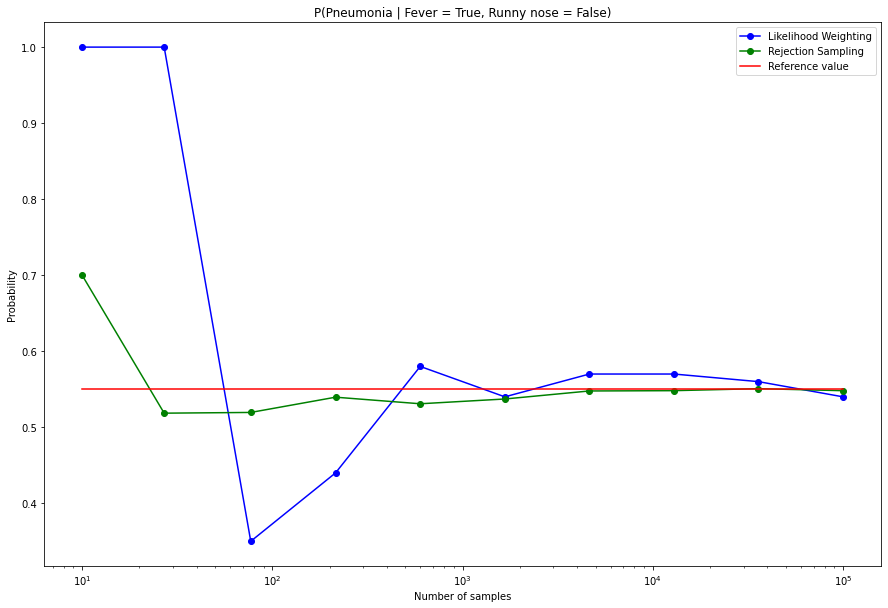

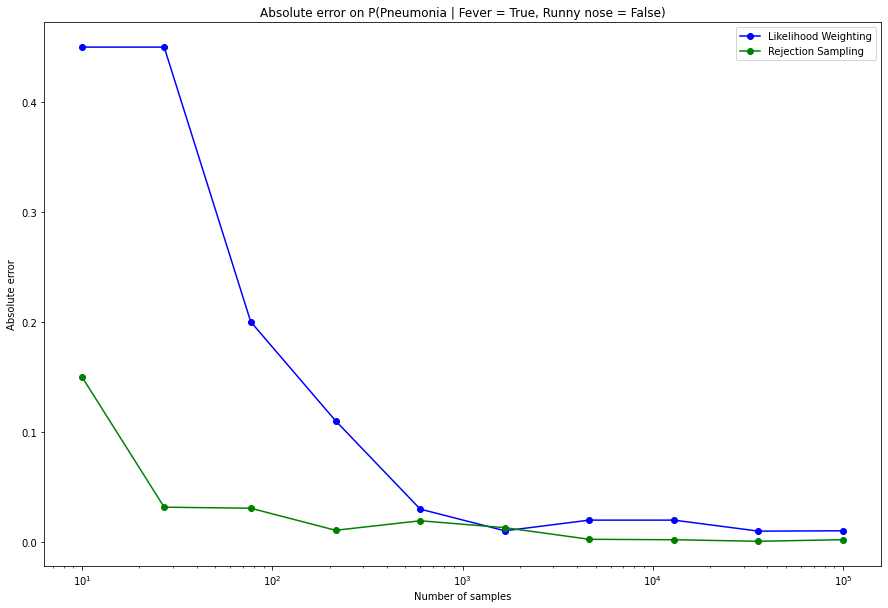

In [ ]:
''' Comparison '''
plt.figure(figsize = (15, 10))
# Plot 1

plt.xlabel("Number of samples")
plt.ylabel("Probability")
plt.title(f'P({pneumonia} | {fever} = True, {runny_nose} = False)')
LWCplot, = plt.semilogx(results['sample_size'],
                        results['query_LW'],
                        '-bo',
                        label = "Likelihood Weighting")

RSCplot, = plt.semilogx(results['sample_size'],
                        results['query_RS'],
                        '-go',
                        label = "Rejection Sampling")

VECplot, = plt.semilogx(results['sample_size'],
                        reference_query*np.ones(results.size),
                        'r',
                        label = "Reference value")

plt.legend(handles = [LWCplot, RSCplot, VECplot])

plt.show()
# Plot 2
plt.figure(figsize = (15, 10))

plt.xlabel("Number of samples")
plt.ylabel("Absolute error")
plt.title(f'Absolute error on P({pneumonia} | {fever} = True, {runny_nose} = False)')
ELWCplot, = plt.semilogx(results['sample_size'],
                         results['e_query_LW'],
                         'bo-',
                         label = "Likelihood Weighting")

ERSCplot, = plt.semilogx(results['sample_size'],
                         results['e_query_RS'],
                         'go-',
                         label = "Rejection Sampling")

plt.legend(handles = [ELWCplot, ERSCplot])

plt.show()

#Conclusion


As we have said above and as we can see from the graphs, the approximate inference method converges to the reference value after a certain number of samples. Thus we can conclude that in our study case, the approximate method doesn't turn out to be very useful since the developed model is kinda small. In conclusion we can assert that the exact inference method is appropriate.
